In [125]:
import bz2
import os
import urllib
import subprocess
from pathlib import Path
import xml.etree.ElementTree as ET
from xml import etree
import pandas as pd
import json
from collections import Counter
import re
import sys
import matplotlib.pyplot as plt
import numpy as np

In [68]:
%matplotlib inline

# Something Some Thing

Requirments:
- Python 3.6
- Jupyter Notebooks (do-oh)

## Download and parse the wikipedia data

In [2]:
# Data
data_url = "https://dumps.wikimedia.org/nowiki/latest/nowiki-latest-pages-articles-multistream.xml.bz2"
data_dirpath = Path.cwd() / "data"
data_extracted_dirpath = data_dirpath / "extracted"
data_filepath = data_dirpath / "nowiki-latest-pages-articles-multistream.xml.bz2"

#WikiExtractor
wikiextractor_github_url = "https://github.com/attardi/wikiextractor"
wikiextractor_dirpath = Path.cwd() / "wikiextractor"

### Download data

In [3]:
%%time
if not os.path.exists(data_filepath):
    print(f"Data file '{data_filepath}' not found. Downloading data.")
    if not os.path.exists(data_dirpath):
        os.makedirs(data_dirpath)
    urllib.request.urlretrieve (data_url, data_filepath)

Wall time: 498 µs


### Extract and parse data

In [4]:
if not os.path.exists(data_extracted_dirpath):
    if not os.path.exists(wikiextractor_dirpath):
        print(f"WikiExtractor not found. Cloining WikiExtractor from '{wikiextractor_github_url}'")
        subprocess.Popen("git clone {wikiextractor_github_url} {wikiextractor_dirpath}")
    print(f"Extracting wikipedia articles to '{data_extracted_dirpath}'")
    subprocess.Popen(f"python {wikiextractor_dirpath}/WikiExtractor.py -o {data_extracted_dirpath} --json {compressed_data_filepath}")

### Load data as a pandas DataFrame

In [5]:
def data_filepath_gen():
    for subdir_name, subdir_list, file_list in os.walk(data_extracted_dirpath):
        for file_name in file_list:
            yield data_extracted_dirpath / subdir_name / file_name

In [6]:
def json2df(json_filepath):
    with open(json_filepath, encoding='utf8') as f:
        json_data = [json.loads(line) for line in f]
        df = pd.DataFrame(json_data)
        return df

In [7]:
def read_wiki_data(max_articles=None):
    num_articles = 0
    all_dfs = []
    
    for filepath in data_filepath_gen():
        sub_df = json2df(filepath)
        all_dfs.append(sub_df)
        num_articles += sub_df.shape[0]
        if max_articles is not None and num_articles >= max_articles:
            break
            
    df = pd.concat(all_dfs, axis=0)
    df.set_index("id", inplace=True)
    if max_articles is not None:
        return df.iloc[:max_articles]
    return df

### Read wordcounts directly 

In [8]:
RE_WORD = re.compile("[^\W\d_]+")

In [9]:
def json2wordcounts(json_filepath):
    with open(json_filepath, encoding='utf8') as f:
        word_counts = Counter()
        for line in f:
            text = json.loads(line).get("text")
            if text is None:
                continue
            word_counts.update(Counter(RE_WORD.findall(text.lower())))
        return word_counts

In [10]:
def get_wiki_wordcounts():
    word_counts = Counter()
    for filepath in data_filepath_gen():
        word_counts.update(json2wordcounts(filepath))
    return word_counts

# Get the wordcounts

In [86]:
%%time
wiki_word_counts = get_wiki_wordcounts()
print(f"Computed word counts for wikipedia articles ({sys.getsizeof(wiki_word_counts) / 1000000:.2f} MB)")
print(f"{len(wiki_word_counts):.3e} unique words found")

Computed word counts for wikipedia articles (83.89 MB)
1.652e+06 unique words found
Wall time: 2min 3s


# Something Some Thing

Compound Words + NLP != <3

# What is Natural Language Processing (NLP)?

Wikipedia defines NLP as:
<font color="gray">_Natural language processing (NLP) is a field of computer science, artificial intelligence and computational linguistics concerned with the interactions between computers and human (natural) languages, and, in particular, concerned with programming computers to fruitfully process large natural language corpora._</font>

## Statistical NLP

- In the early days NLP typically involved hand coding of rules
- Now NLP relies heavily on **Machine Learning** to _statistically_ infer rules from a large collection of text examples (e.g. documents) 

## What are some use cases of NLP?

- Text Categorization
- Information Retrieval
- Named Entity Recognition
- Intent Recognition
- Part-of-Speech Tagging
- Sentiment Analysis

And many other tasks which include extracting information from text, or classifying text

## How can Machine Learning be used for NLP?

- All Machine Learning algorithms try to map a set of _features_ to some _target_
- Each training example given to the ML algortihm must be a _collection of the specified features_
- In NLP the examples are _texts_ -> **we need some way of generating features from text**

## Words as Features

- One common approach is to treat the **words** of the text as the features
- The words of a text are all coherent sequences of (alphanumeric) characters, separated by _spaces_

For example:

In [16]:
word_pattern = "[A-Za-z]+"
text = "These are five different words"
all_words = re.findall(word_pattern, text)
all_words

['These', 'are', 'five', 'different', 'words']

## Bag-of-words

- All ML algorithms expect the examples to be _collections of numbers_ of _equal length_
- -> A list of words is not a valid representation of a text
- One algorithm used to transform a text into a collection of numbers is called **bag-of-words**
- _Bag-of-words_ maps all unique words into separate columns in your data set

## BOW example

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
texts = [
    "This is some text",
    "And this is some other text",
    "Text text text text"
]

vec = CountVectorizer()
bow = vec.fit_transform(texts)

pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,and,is,other,some,text,this
0,0,1,0,1,1,1
1,1,1,1,1,1,1
2,0,0,0,0,4,0


# Why is Compound Words + NLP a bad match?

## What are compound words?

- Compound words are words that consist of more than one stem. 
- One example is the word "særskrivingsfeil" which consists of the stems "særskriving" and "feil"
- In Scandinavian languages compound words are very common

- In English they are very rare
- A lot of traditional NLP techniques were designed for english...

# Why do they cause trouble in NLP?

In [16]:
texts = [
    "Jeg har en reiseregning",
    "Jeg har en regning for en reise"
]

vec = CountVectorizer()
bow = vec.fit_transform(texts)

pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,en,for,har,jeg,regning,reise,reiseregning
0,1,0,1,1,0,0,1
1,2,1,1,1,1,1,0


Text similarity (cosine similarity)

In [17]:
bow[0].dot(bow[1].T)[0,0] / bow.shape[1]

0.5714285714285714

### And when removing stopwords ...

In [28]:
stopwords = ["jeg", "har", "en", "for"]

vec = CountVectorizer(stop_words=stopwords)
bow = vec.fit_transform(texts)

pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,regning,reise,reiseregning
0,0,0,1
1,1,1,0


Text similarity (cosine distance)

In [29]:
bow[0].dot(bow[1].T)[0,0] / bow.shape[1]

0.0

Aka not good ...

# Compound words => Many, very rare features + subword-information is lost

# What if we could create some mapping between compounds and the stems they are created from?

## Example

In [23]:
mapping = {
    "reiseregning": "reise regning"
}

clean_text = lambda text: " ".join([mapping.get(x, x) for x in text.split()])
 
texts2 = [clean_text(text) for text in texts]
texts2

['Jeg har en reise regning', 'Jeg har en regning for en reise']

In [24]:
vec = CountVectorizer(stop_words=stopwords)
bow = vec.fit_transform(texts2)

pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,regning,reise
0,1,1
1,1,1


Text similarity (cosine distance)

In [25]:
bow[0].dot(bow[1].T)[0,0] / bow.shape[1]

1.0

Much better!

# How can we find this mapping?

## Option 1: Manually define all valid word stems, or find a dictionary of stems

<center><img src="https://memegenerator.net/img/instances/60127190.jpg"></center>

## Option 2: Automatically find a list of words from your own corpora

<center><img src="https://media1.tenor.com/images/b5b525642d31fc32571618da55f973e5/tenor.gif?itemid=4786736"></center>

# Algorithm for automatic compound word splitting

## Algorithm for automatic compound word splitting

1. Extract all valid words from your corpora, and their counts
2. Discard any words that are _too rare_ or _too common_ (stopwords)
3. For all words of length >= n:
    - consider all possible splits of the word
    - choose the most probable split, or no split

## Step 1: Finding all valid words

In [36]:
article = read_wiki_data(1).iloc[0]
print(f"{article.text[:500]} ...")

Akershus

Akershus (fra norrønt "akr", åker, og "hús", borg eller kastell) er et norsk fylke, som grenser mot Hedmark i øst, Oppland i nord, Buskerud i vest, Østfold i sør og Oslo. Dessuten har Akershus (i kommunen Aurskog-Høland) en liten bit av riksgrensen mot Sverige i øst.

Akershus er delt i tre regioner: Romerike, Follo og Vestområdet,
hvorav sistnevnte med kommunene Asker og Bærum ligger vest for Oslofjorden og sydvest for Oslo. Øst for Oslofjorden ligger Follo, mens Romerike ligger øst o ...


In [37]:
from collections import Counter

In [46]:
RE_WORD = re.compile("[^\W\d_]+")
article_word_counts = Counter(RE_WORD.findall(article.text.lower()))

In [51]:
article_word_counts.most_common(5)

[('og', 60), ('i', 60), ('akershus', 39), ('er', 39), ('oslo', 19)]

## If we repeat this for all norwegian wikipedia articles...

In [58]:
wiki_word_counts.most_common(10)

[('i', 3953876),
 ('og', 2879012),
 ('av', 1715924),
 ('som', 1552470),
 ('en', 1496552),
 ('er', 1409112),
 ('til', 1257523),
 ('på', 1169964),
 ('ble', 998262),
 ('den', 983530)]

### Word count histogram

[]

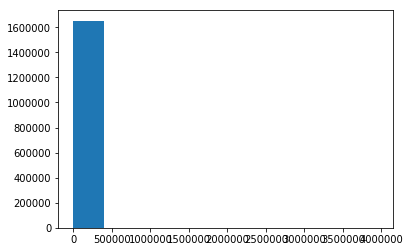

In [76]:
plt.hist(wiki_word_counts.values())
plt.plot()

Many very rare features ...

Total number of unique words:

In [62]:
print(f"{len(wiki_word_counts):.2e} words")

1.65e+06 words


Number of words used at most _n_ times:

In [105]:
n = 1
print(f"{len([w for w, c in wiki_word_counts.items() if c <= n]):.2e} words")

8.41e+05 words


## Step 2: Discard words that are too common or too rare

### Drop words that are too common

In [106]:
from nltk.corpus import stopwords

In [107]:
stopwords.words("norwegian")[:10]

['og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den', 'til', 'er']

In [108]:
wiki_word_counts2 = wiki_word_counts.copy()
for sw in stopwords.words("norwegian"):
    if sw not in wiki_word_counts2:
        continue
    wiki_word_counts2.pop(sw)

In [109]:
wiki_word_counts2.most_common(3)

[('under', 250723), ('andre', 180805), ('første', 172290)]

### Drop words that are too rare

In [110]:
min_word_count = 3
wiki_word_counts2 = {w: c for w, c in wiki_word_counts2.items() if c >= min_word_count}
wiki_word_counts2 = Counter(wiki_word_counts2)

Number of words left:

In [111]:
print(f"{len(wiki_word_counts2):.2e} words")

5.68e+05 words


### Select only words consiting of at least 3 characters

In [286]:
min_word_length = 3
wiki_word_counts2 = {w: c for w, c in wiki_word_counts2.items() if len(w) >= min_word_length}
wiki_word_counts2 = Counter(wiki_word_counts2)

Number of words left:

In [287]:
print(f"{len(wiki_word_counts2):.2e} words")

5.65e+05 words


# We now how a pretty good dictionary!

## Step 3: Find the most probable split of a word

Key ideas: 
- All words after the split must be valid words
- The split resulting in the _highest total word count_ for the subwords, is the most probable

### Example: Reise + Regning > Reiseregning

In [97]:
wiki_word_counts2["reise"]

7234

In [98]:
wiki_word_counts2["regning"]

369

In [99]:
wiki_word_counts2["reiseregning"]

0

In [100]:
wiki_word_counts2["reise"] + wiki_word_counts2["regning"] > wiki_word_counts2["reiseregning"]

True

## Defining the split cost

In [180]:
INF = 1e9

def split_value(*subwords):
    return sum(wiki_word_counts2.get(sw, -INF) for sw in subwords)

In [181]:
split_value("reise", "regning")

7603

In [182]:
split_value("reiseregning")

-1000000000.0

## Problem: very common words dominating

A word appearing 100,000 is probably not 100 times more probable than a word appearing 1000 times. A word appearing 1000 times is still a very common word.

## Solution: use the _log_ of the word count instead

In [145]:
from math import log

In [193]:
def word_value(word):
    if word in wiki_word_counts2:
        return log(wiki_word_counts2[word])
    return -INF

def split_value2(*subwords):
    return sum(word_value(subword) for subword in subwords)

In [194]:
split_value2("reise", "regning")

14.79734405655257

In [195]:
split_value2("reiseregning")

-1000000000.0

## How does the _log_ function look?

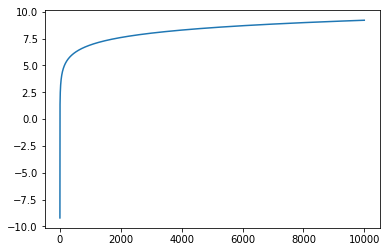

In [136]:
x = np.arange(0.0001, 10000)
y = np.log(x)
plt.plot(x, y)
plt.show()

In [152]:
print(f"100000/100 = {100000/100}")
print(f"log(100000) / log(100) = {log(100000) / log(100)}")

100000/100 = 1000.0
log(100000) / log(100) = 2.5


# Case: To split or not to split

If the word "reiseregning" appears 2000 times in your corpora, and the words "reise" and "regning" appear 500 times each - should we stil split it?

In [187]:
log(500) + log(500)

12.429216196844383

In [188]:
log(2000)

7.600902459542082

According to the cost function we defined we should split this word, but intuition tells us we should not.

## Split penalty: To prevent "over-eager" splitting

Let's say we add a plit penalty of e.g. 5 to the split value. Then:

In [201]:
SPLIT_PENALTY = 5

In [202]:
log(500) + log(500) - SPLIT_PENALTY < log(2000)

True

## How do we find all possible splits and select the best one?

Solution: Iterate over all possible solutions and select the best one

In [288]:
word = "reiseregning"
for i in range(min_word_length, len(word)-min_word_length+1):
    print(word[:i], word[i:])

rei seregning
reis eregning
reise regning
reiser egning
reisere gning
reisereg ning
reiseregn ing


# Putting it all together

In [289]:
def find_best_split(word):
    # No split
    max_value, best_split= word_value(word), word
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1, sw2 = word[:i], word[i:]
        value = split_value2(sw1, sw2) - SPLIT_PENALTY
        if value > max_value:
            max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

In [290]:
find_best_split("reiseregning")

('reise regning', 9.79734405655257)

In [291]:
find_best_split("brukerkonto")

('bruker konto', 9.946822988014759)

## Corner case 1: Words with glue-letters

In [292]:
find_best_split("særskrivingsfeil")

('særskrivingsfeil', 1.791759469228055)

In [293]:
word_value("særskrivings")

-1000000000.0

In [294]:
word_value("særskriving")

3.044522437723423

## Corner case 1: Solution - consider "remvoving" glue letters

In [295]:
GLUE_LETTERS = "s"
EDIT_PENALTY = 1

def find_best_split2(word):
    # No split
    max_value, best_split= word_value(word), word
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1, sw2 = word[:i], word[i:]
        value = split_value2(sw1, sw2) - SPLIT_PENALTY
        if value > max_value:
            max_value, best_split = value, sw1 + " " + sw2
            
        if word[i] in GLUE_LETTERS:
            sw2 = word[i+1:]
            value = split_value2(sw1, sw2) - SPLIT_PENALTY - EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

### Now, let's try to split "særskrivingsfeil"

In [296]:
find_best_split2("særskrivingsfeil")

('særskriving feil', 5.468064073058205)

## Corner case 2: Words ending on double consonants

In [297]:
find_best_split2("internettilgang")

('internet tilgang', 9.67788898990056)

The correct split should be "internett" + "tilgang"

## Corner case 2: Solution - consider "adding" another consonant

In [298]:
def find_best_split3(word):
    # No split
    max_value, best_split= word_value(word), word
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1, sw2 = word[:i], word[i:]
        value = split_value2(sw1, sw2) - SPLIT_PENALTY
        if value > max_value:
            max_value, best_split = value, sw1 + " " + sw2
            
        if word[i] in GLUE_LETTERS:
            sw2 = word[i+1:]
            value = split_value2(sw1, sw2) - SPLIT_PENALTY - EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
                
        if word[i-1] in 'bcdfghjklmnpqrstvxz' and word[i-1] == word[i-2]:
            sw2 = word[i-1:]
            value = split_value2(sw1, sw2) - SPLIT_PENALTY - EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

### Now, let's try to split "internettilgang"

In [299]:
find_best_split3("internettilgang")

('internett tilgang', 10.246441195285314)

## Some code clean-up

In [300]:
def find_best_split4(word):
    # No split
    max_value, best_split= word_value(word), word
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1 = word[:i]
        sw1_value = word_value(sw1)
        
        split_options = [i]
        if word[i] in GLUE_LETTERS:
            split_options.append(i+1)
        if word[i-1] in 'bcdfghjklmnpqrstvxz' and word[i-1] == word[i-2]:
            split_options.append(i-1)
            
        for j in split_options:
            sw2 = word[j:]
            value = sw1_value + word_value(sw2) - SPLIT_PENALTY - (j!=i) * EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

## Corner case 3: Words consisting of more than 2 subwords

In [301]:
find_best_split4("førstegangsintervju")

('førstegangs intervju', 5.6677919274124005)

In [302]:
find_best_split4("førstegangs")

('første gangs', 12.087372303918887)

=> Words will not be split consistently. Not good ...

## Corner case 3: Solution - run the function recursively

In [322]:
def find_best_split5(word):
    # No split
    max_value, best_split= word_value(word), word
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1 = word[:i]
        sw1_value = word_value(sw1)
        
        split_options = [i]
        if word[i] in GLUE_LETTERS:
            split_options.append(i+1)
        if word[i-1] in 'bcdfghjklmnpqrstvxz' and word[i-1] == word[i-2]:
            split_options.append(i-1)
            
        for j in split_options:
            sw2, sw2_value = find_best_split5(word[j:])
            value = sw1_value + sw2_value - SPLIT_PENALTY - (j!=i) * EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

### Now, let's try to split "førstegangsintervju"

In [350]:
find_best_split5("førstegangsintervju")

('første gang intervju', 19.370104879581454)

## Corner case 4: Eager splitting

In [319]:
find_best_split5("regning")

('regn ing', 7.912333465235502)

Not all words should be split

## Corner case 4: Solution - exception list

In [329]:
DO_NOT_SPLIT = ["regning"]

def find_best_split6(word):
    # No split
    max_value, best_split= word_value(word), word
    if word in DO_NOT_SPLIT:
        return best_split, max_value
    
    # Consider all splits
    for i in range(min_word_length, len(word)-min_word_length+1):
        sw1 = word[:i]
        sw1_value = word_value(sw1)
        
        split_options = [i]
        if word[i] in GLUE_LETTERS:
            split_options.append(i+1)
        if word[i-1] in 'bcdfghjklmnpqrstvxz' and word[i-1] == word[i-2]:
            split_options.append(i-1)
            
        for j in split_options:
            sw2, sw2_value = find_best_split6(word[j:])
            value = sw1_value + sw2_value - SPLIT_PENALTY - (j!=i) * EDIT_PENALTY
            if value > max_value:
                max_value, best_split = value, sw1 + " " + sw2
    
    return best_split, max_value

## Now, let's try "regning" again

In [330]:
find_best_split6("regning")

('regning', 5.910796644040527)

# Let's try our algorithm on the example from earlier

In [331]:
texts = [
    "Jeg har en reiseregning",
    "Jeg har en regning for en reise"
]

clean_text = lambda text: " ".join(find_best_split6(word)[0] for word in text.split())
 
texts2 = [clean_text(text) for text in texts]
texts2

['Jeg har en reise regning', 'Jeg har en regning for en reise']

In [333]:
vec = CountVectorizer(stop_words=stopwords.words("norwegian"))
bow = vec.fit_transform(texts2)
pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,regning,reise
0,1,1
1,1,1


Text similarity

In [334]:
bow[0].dot(bow[1].T)[0,0] / bow.shape[1]

1.0

<center><img src="https://media1.tenor.com/images/b5b525642d31fc32571618da55f973e5/tenor.gif?itemid=4786736"></center>

# Ending notes

- A compound word splitter is not the only way to solve the problem of compound words
- Another way to approach this problem is using character-level features instead of word-level features
- The compound word splitter may not work properly if your corpora is too small, because you may not be able to get proper word counts

## Character-level features

In [347]:
texts = [
    "Visma er bra", "Karisma er bra"
]
vec = CountVectorizer(analyzer="char", ngram_range=(3,3))
bow = vec.fit_transform(texts)
pd.DataFrame(bow.todense(), columns=vec.get_feature_names())

,br,er,a e,ari,bra,er,ism,kar,ma,r b,ris,sma,vis
0,1,1,1,0,1,1,1,0,1,1,0,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [348]:
bow[0].dot(bow[1].T)[0,0] / bow.shape[1]

0.69230769230769229

Character-level features cause other types of problems...